In this notebook, we generate a ```LogNormalCatalog``` at  using the Planck 2015 cosmology parameters and the Eisenstein-Hu linear power spectrum fitting formula. We then plot the power spectra in both real and redshift space and compare to the input linear power spectrum.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [21]:
import numpy as np
from nbodykit.lab import *
from nbodykit import style, setup_logging
setup_logging()
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [6]:
redshift = 0.55
cosmo = cosmology.Planck15
b1 = 2.0 # linear bias fator: gal density = b1* matter density
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

[ 000763.86 ]   0: 06-15 10:45  LogNormalCatalog INFO     Growth Rate is 0.770123
[ 000763.86 ]   0: 06-15 10:45  LogNormalCatalog INFO     Generating whitenoise
[ 000766.75 ]   0: 06-15 10:45  LogNormalCatalog INFO     Write noise generated
[ 000768.43 ]   0: 06-15 10:45  LogNormalCatalog INFO     Displacement computed in fourier space
[ 000769.33 ]   0: 06-15 10:45  LogNormalCatalog INFO     Overdensity computed in configuration space: std = 1.1929580837889608
[ 000771.59 ]   0: 06-15 10:45  LogNormalCatalog INFO     Displacement computed in configuration space: std = [4.238011674174512, 4.235169508603116, 4.313347332404491]
[ 000771.60 ]   0: 06-15 10:45  LogNormalCatalog INFO     gaussian field is generated
[ 000772.56 ]   0: 06-15 10:45  LogNormalCatalog INFO     Lognormal transformation done
[ 000776.95 ]   0: 06-15 10:45  LogNormalCatalog INFO     Poisson sampling done, total number of objects is 7886734
[ 000805.53 ]   0: 06-15 10:46  LogNormalCatalog INFO     catalog produced.

### Real space power spectrum $P(k, \mu)$
Since $P$ is function of two parameters, select a few (here 5) values of $\mu$ and plot P as a function of $k$.
Note that P(k, $\mu$) = P(k, -$\mu$) when $|\mu| < 1$. Hence, in plots below, only expect to see 3 distinct graphs: $\mu=0.8$ is drawn on top of $\mu=-0.8$ and similarly for $|\mu|=0.4$.

In tutorials get 

In [7]:
# convert the catalog to the mesh, with CIC interpolation
real_mesh = cat.to_mesh(compensated=True, window='cic', position='Position')

# compute the 2d P(k,mu) power, with 5 mu bins
# according to docs should have 0<mu<1 but get -1<mu<1. Mentioned in issue 663. Apparently even multipoles are sym in |mu|<1
r = FFTPower(real_mesh, mode='2d', Nmu=5)
pkmu = r.power # shape: (128,5) = (k bins, mu bins)

/tmp/ipykernel_1810139/1437778835.py:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  real_mesh = cat.to_mesh(compensated=True, window='cic', position='Position')
[ 001147.38 ]   0: 06-15 10:52  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 7886734 
[ 001154.49 ]   0: 06-15 10:52  CatalogMesh     INFO     painted 4194304 out of 7886734 objects to mesh
[ 001154.49 ]   0: 06-15 10:52  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 7886734 
[ 001158.19 ]   0: 06-15 10:52  CatalogMesh     INFO     painted 7886734 out of 7886734 objects to mesh
[ 001158.20 ]   0: 06-15 10:52  CatalogMesh     INFO     painted 7886734 out of 7886734 objects to mesh
[ 001158.20 ]   0: 06-15 10:52  CatalogMesh     INFO     mean particles per cell is 0.470086
[ 001158.20 ]   0: 06-15 10:52  CatalogMesh     INFO     sum is 7.88673e+06 
[ 001158.22 ]   0: 06-15 10:52  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 001158.52 ]   0: 06-15 10:52  CatalogMesh  

Useful attributes of result:
- pkmu.coords gives all values of k and mu at which power has been computed
- pkmu.attrs gives input paras and meta data such as shotnoise

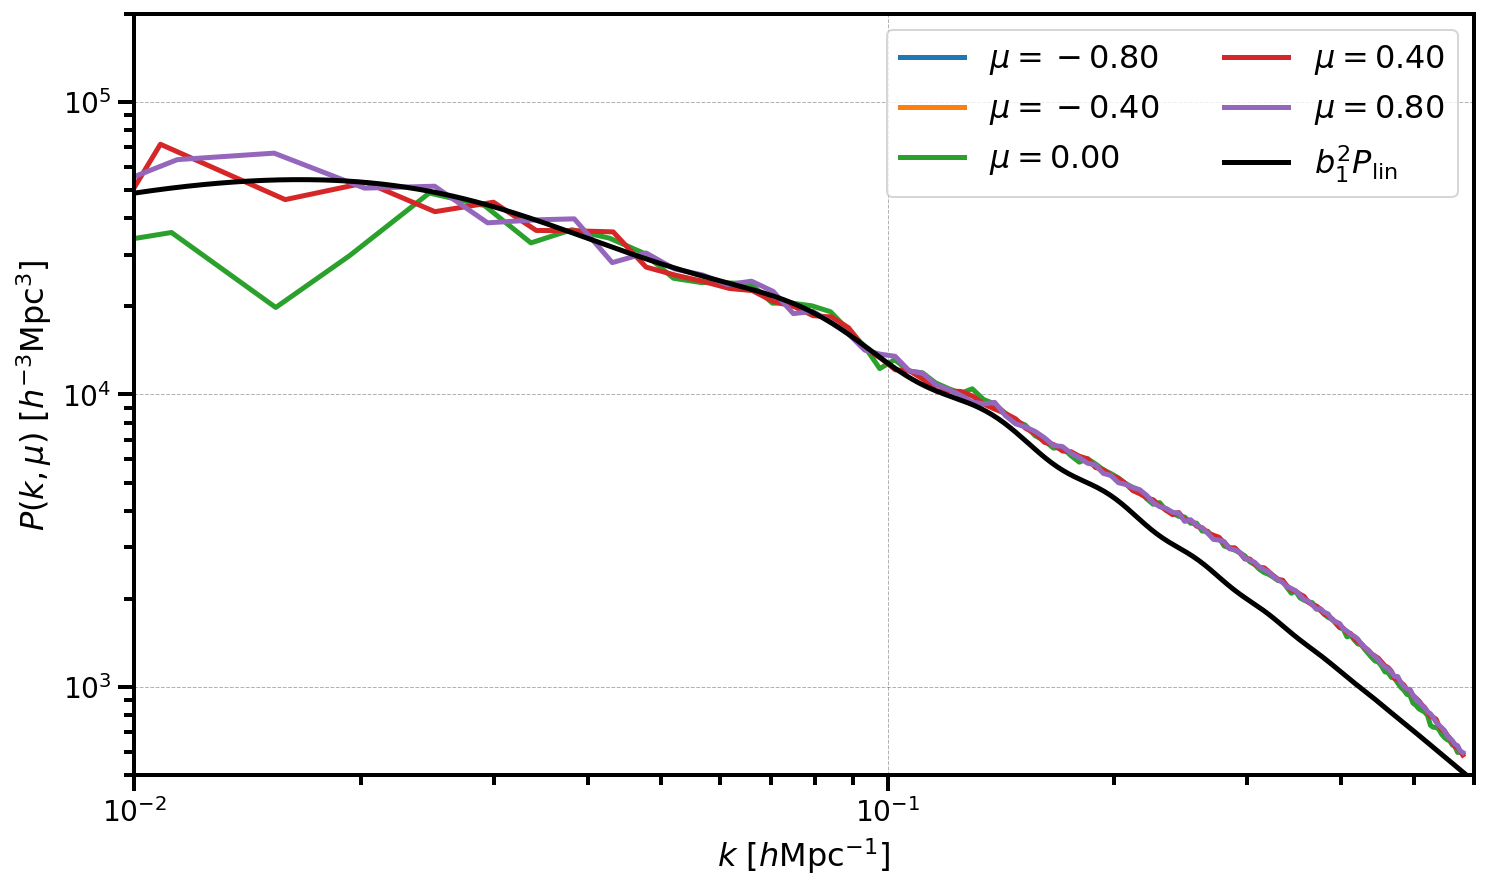

In [22]:
# make plots
# pkmu is matrix with each column containg P(k) data vector for different values of mu 
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i] # select i-th column
    mu = pkmu.coords['mu'][i] # get value of current mu
    label = "$\mu={:.1f}$".format(mu)
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)
    
# plot the biased linear power spectrum
k = np.logspace(-2,0,512)
plt.loglog(k, b1**2*Plin(k), c='k', label=r'$b_1^2 P_\mathrm{lin}$')

# lengend and axis
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.ylim(500, 2e5)
plt.show()

### Interpretation
The real space power spectrum is largely independent of $\mu$ i.e. direction independent: space isotropy. 

At large $k$ find disagreement resulting from using Zel'dovich approximation in generating ```LogNormalCatalog``` (note that ```cat``` is generated using ```Plin```). Disagreement due to non-linear evolution.

### Redshift space power spectrum $P(k, \mu)$

In [24]:
def kaiser_pkmu(k, mu):
    """Returns P(k,mu) in redshift space, following Kaiser's linear results.
    See Hamilton's review eq 4.36."""
    beta = cosmo.scale_independent_growth_rate(redshift) / b1
    return (1 + beta*mu**2)**2 *b1**2 * Plin(k)

In [26]:
# add RSD along z-axis. See Getting Started->adding redshift space distortion
LOS = [0,0,1]
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset'] * LOS 

In [28]:
# make mesh and compute 2D power
rsd_mesh = cat.to_mesh(compensated=True, window='cic', position='RSDPosition')
r = FFTPower(rsd_mesh, mode='2d', Nmu=5, los=LOS)
pkmu = r.power

/tmp/ipykernel_1810139/3260445523.py:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  rsd_mesh = cat.to_mesh(compensated=True, window='cic', position='RSDPosition')
[ 003353.39 ]   0: 06-15 12:07  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 7886734 
[ 003362.45 ]   0: 06-15 12:07  CatalogMesh     INFO     painted 4194304 out of 7886734 objects to mesh
[ 003362.46 ]   0: 06-15 12:07  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 7886734 
[ 003367.35 ]   0: 06-15 12:07  CatalogMesh     INFO     painted 7886734 out of 7886734 objects to mesh
[ 003367.36 ]   0: 06-15 12:07  CatalogMesh     INFO     painted 7886734 out of 7886734 objects to mesh
[ 003367.36 ]   0: 06-15 12:07  CatalogMesh     INFO     mean particles per cell is 0.470086
[ 003367.36 ]   0: 06-15 12:07  CatalogMesh     INFO     sum is 7.88673e+06 
[ 003367.38 ]   0: 06-15 12:07  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 003367.81 ]   0: 06-15 12:07  CatalogMesh

/tmp/ipykernel_1810139/3750749939.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(Pk['k'], P / kaiser_pkmu(Pk['k'], mu), label=label)


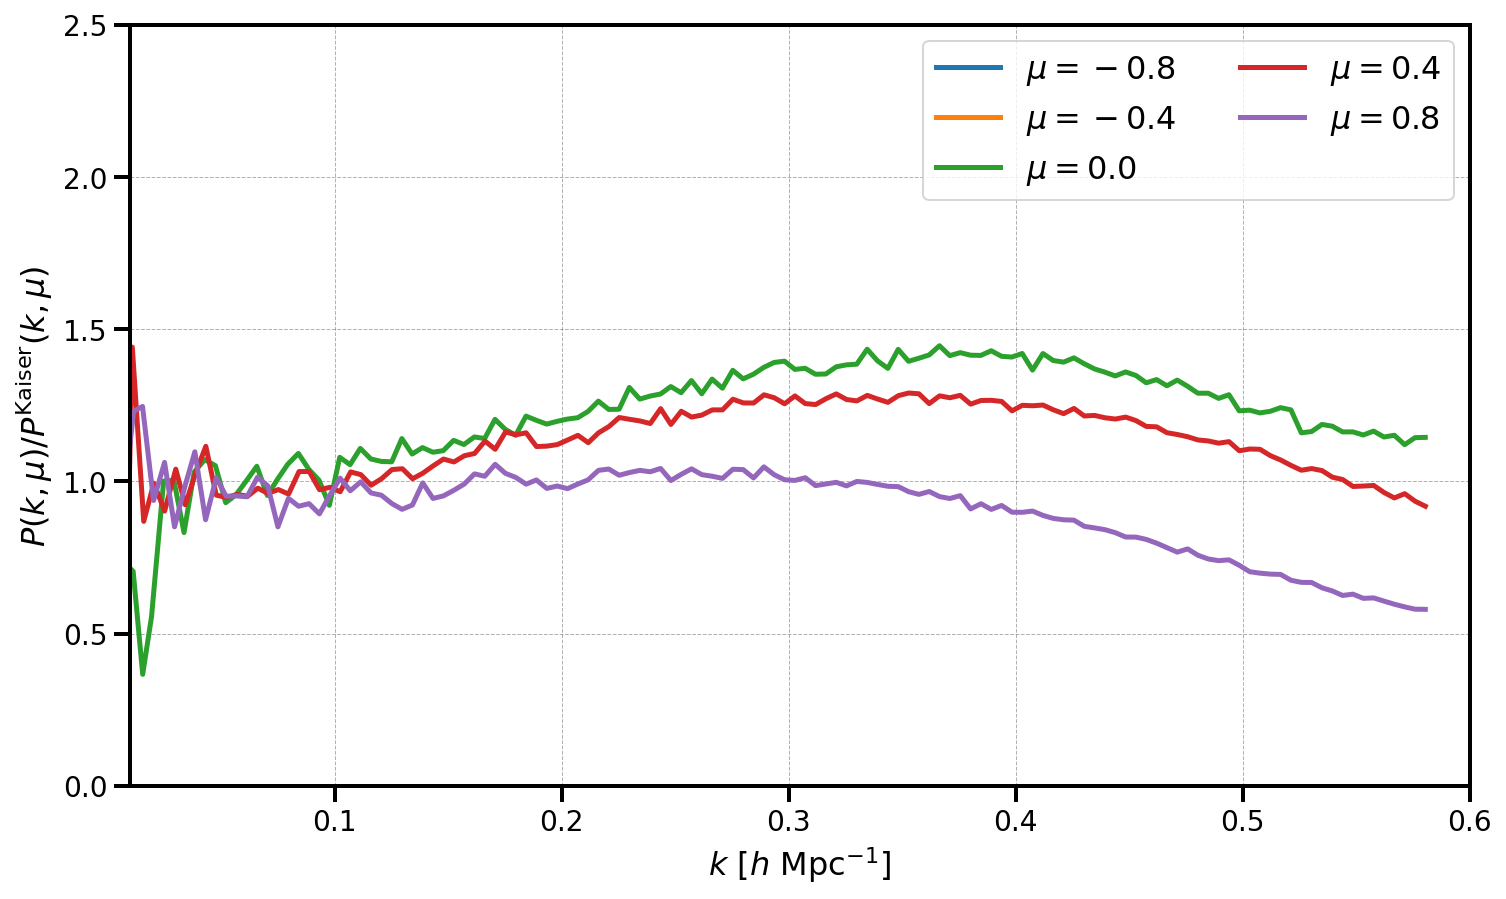

In [29]:
# plot each mu power bin, normalized by the expected Kaiser power
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i]
    mu = pkmu.coords['mu'][i]
    label = "$\mu={:.1f}$".format(mu)

    P = Pk['power'].real-Pk.attrs['shotnoise']
    plt.plot(Pk['k'], P / kaiser_pkmu(Pk['k'], mu), label=label)

# add a legend and axis labels
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu) / P^\mathrm{Kaiser}(k,\mu)$")
plt.xlim(0.01, 0.6)
plt.ylim(0, 2.5)
plt.show()

Note that at low k, we expect linear theory to hold, i.e. power spectra should agree with Kaiser's result as shown in graph.

Effect of RSD: larger $\mu$, i.e angle between $k$ and LOS goes to 0, more damped at high $k$.